In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import scipy
import pymc as pm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Example on one cohort

def n_lost(data):
    lost = [None]
    for i in range(1, len(data)):
        lost.append(data[i - 1] - data[i])
    return lost

data_raw = [1000, 631, 468, 382, 326, 289, 262, 241, 223, 207, 194, 183, 173]

num_periods = len(data_raw)

data_n_lost = n_lost(data_raw)
data = (data_raw, data_n_lost)

alpha = pm.Uniform('alpha', 0.00001, 1000, value=1) 
beta = pm.Uniform('beta', 0.00001, 1000, value=1)

@pm.deterministic
def P_T_is_t(alpha=alpha, beta=beta, num_periods=num_periods):
    p = [None, alpha / (alpha + beta)]
    for t in range(2, num_periods):
        pt = (beta + t - 2) / (alpha + beta + t - 1) * p[t-1]
        p.append(pt)
    return p

@pm.deterministic
def survival_function(P_T_is_t=P_T_is_t, num_periods=num_periods):
    s = [None, 1 - P_T_is_t[1]]
    for t in range(2, num_periods):
        s.append(s[t-1] - P_T_is_t[t])
    return s

@pm.observed
def retention_rates(P_T_is_t=P_T_is_t, survival_function=survival_function, value=data):
    def logp(value, P_T_is_t, survival_function):
        
        active, lost = value
        
        # Those who've churned along the way...
        died = np.log(P_T_is_t[1:]) * lost[1:]
        
        # and those still active in last period
        still_active = np.log(survival_function[-1]) * active[-1]              
        return sum(died) + still_active
    

mcmc = pm.MCMC([alpha, beta, P_T_is_t, survival_function, retention_rates])

In [4]:
mcmc.sample(25000,5000,20)

 [-----------------100%-----------------] 25000 of 25000 complete in 4.6 sec

In [5]:
df_trace = pd.DataFrame({'alpha': alpha.trace(), 'beta': beta.trace()})
df_trace.median()

alpha    0.706057
beta     1.193218
dtype: float64

In [6]:
alpha = df_trace["alpha"].median()
beta = df_trace["beta"].median()

In [7]:
def get_predictions(years, hist_data, alpha, beta):
    init = hist_data[0]
    retention = [1]
    preds = [init]
    exp_calc = 1
    exp_lifetime = 0
    for current_year in range(1, years + 1):
        retention.append((beta + current_year - 1) / (alpha + beta + current_year - 1))
        preds.append(preds[current_year - 1] * retention[current_year])
        exp_calc = exp_calc * retention[current_year]
        exp_lifetime = exp_lifetime + exp_calc
    return(retention, preds, exp_lifetime)

In [8]:
retention, predicted, expected_lifetime = get_predictions(12, data_raw, alpha, beta)

In [9]:
expected_lifetime

3.5899928808831554

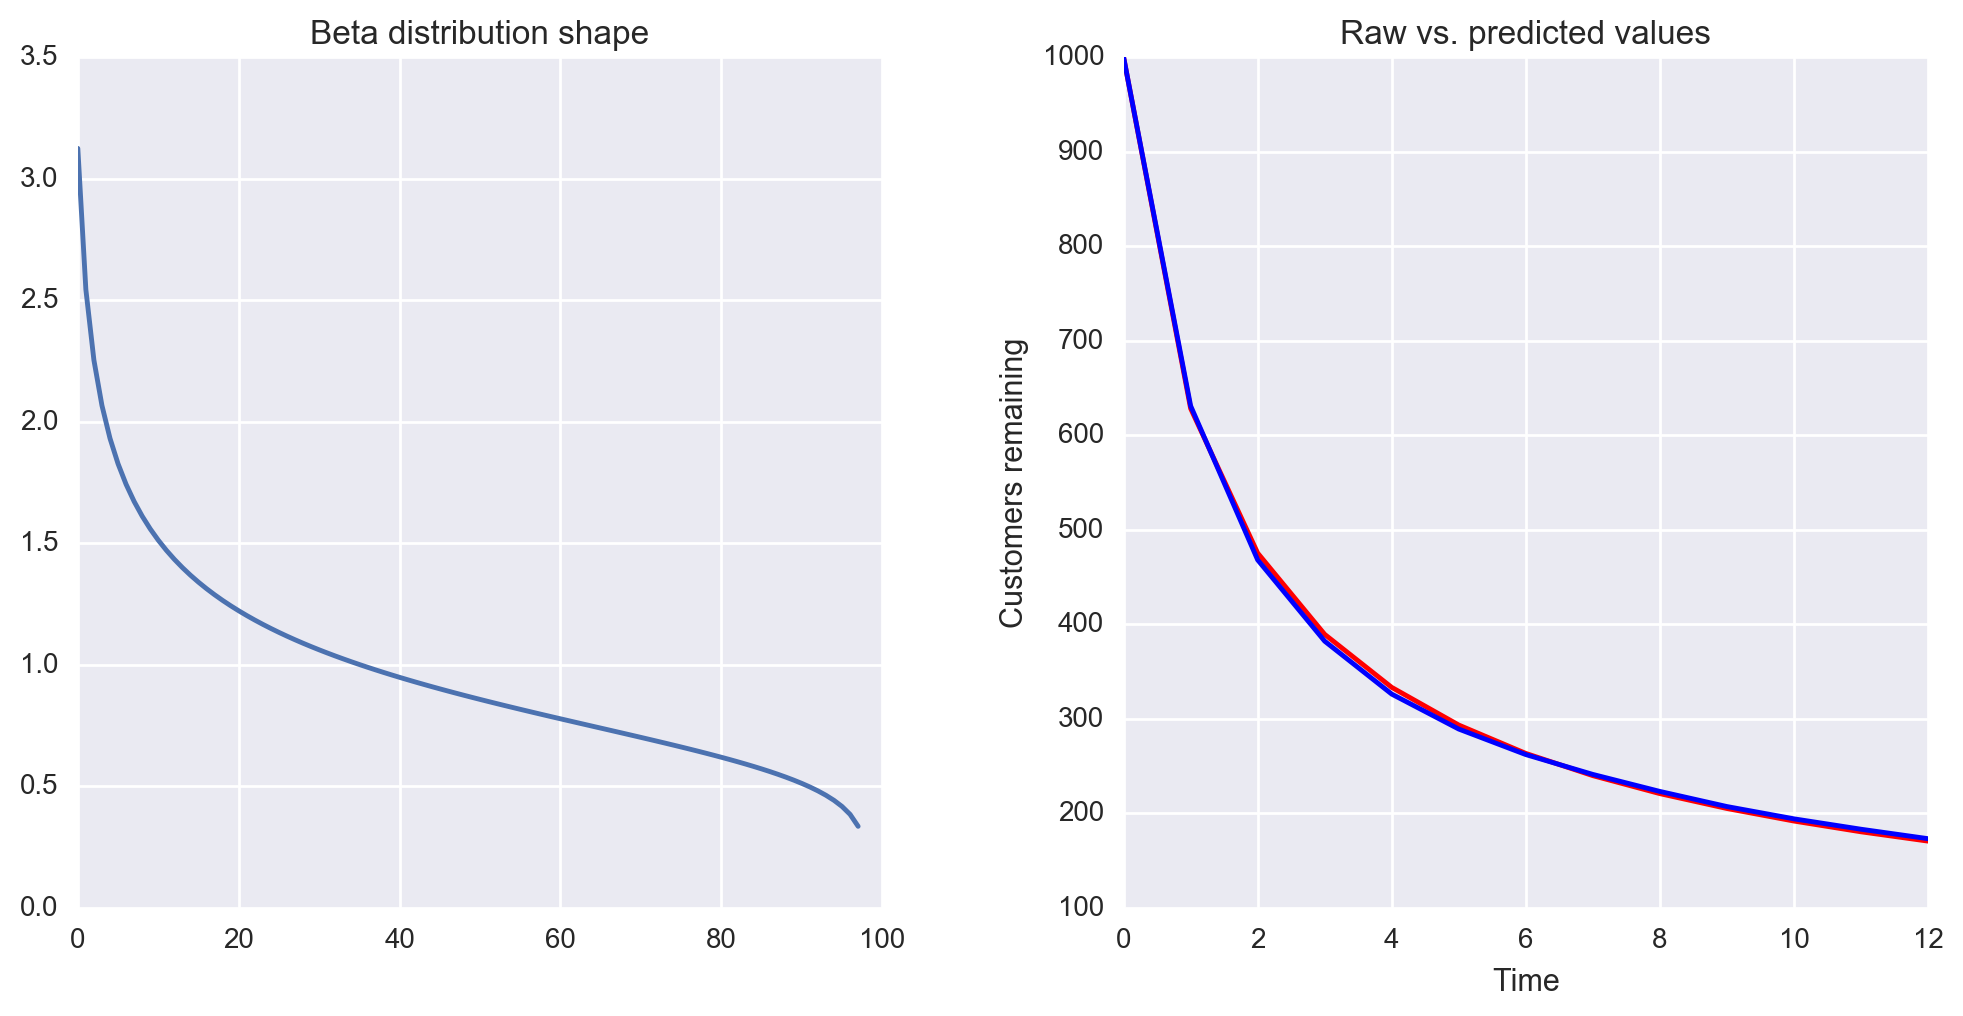

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
fig.tight_layout()


plt.subplot(2, 2, 1)
plt.plot(scipy.stats.beta.pdf(np.linspace(0, 1, 100)[1:99], alpha, beta))
plt.title('Beta distribution shape')


plt.subplot(2,2,2)
plt.plot(predicted, 'r')
plt.plot(data_raw, 'b')
plt.title('Raw vs. predicted values')
plt.ylabel('Customers remaining')
plt.xlabel('Time')

plt.subplots_adjust(wspace=.3)


plt.show()